# Modeling

In [1]:
!pwd

/home/jovyan/work/cold_start_models


In [2]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = y_test
    y_pred = y_pred
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [4]:
with open('/home/jovyan/work/cold_start_models/dataset_kp0.pkl', 'rb') as f:
    df_pr = pickle.load(f)
    
with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset-avg.pkl', 'rb') as f:
    df_target = pickle.load(f)

In [54]:
df_target[df_target['name'] == 'Оффлайн']

,actor,age_access_type,country,average_rating,duration,availability,type,name,release_year,genre,director,subscription_only,uid,target
12167,"[63609326-00d3-45f5-9d6c-d8245026d740, 2de47f4...",18,[russia],7.7,30060000,[SUBSCRIPTION],SERIAL,Оффлайн,2022,"[Thriller, Drama, Detective]",[b4ed432a-edfc-4853-89ec-a0f4bd22c88f],True,49a3d528-44c0-408e-b6fc-a1507ce7641a,105171.0


In [5]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age_access_type  8104 non-null   object 
 1   type             8104 non-null   object 
 2   actor_0          8104 non-null   object 
 3   actor_1          8104 non-null   object 
 4   actor_2          8104 non-null   object 
 5   actor_3          8104 non-null   object 
 6   actor_4          8104 non-null   object 
 7   actor_5          8104 non-null   object 
 8   actor_6          8104 non-null   object 
 9   actor_7          8104 non-null   object 
 10  actor_8          8104 non-null   object 
 11  actor_9          8104 non-null   object 
 12  country_0        8104 non-null   object 
 13  director_0       8104 non-null   object 
 14  editor_0         8104 non-null   object 
 15  operator_0       8104 non-null   object 
 16  producer_0       8104 non-null   object 
 17  producer_1    

In [6]:
df_pr.isnull().sum()[df_pr.isnull().sum() > 0]

budget       5658
marketing    7879
rus          4768
world        3939
dtype: int64

In [7]:
df_pr.shape

(8104, 39)

In [8]:
df_target.shape

(12223, 14)

In [9]:
df_pr = df_pr.merge(df_target[['target', 'uid']], on='uid')

In [10]:
df_pr.shape

(8104, 40)

In [11]:
okko_originals = [
                    7472, # Чикатило
                    7896, # Манюня
                    8067,  # Оффлайн
    
]

In [12]:
df_pr.loc[okko_originals, :]['uid'].values

array(['ee48def6-c311-4b73-a878-1a5d3d1679a3',
       '9b202b16-55bf-418a-b01d-9f0329b18790',
       '49a3d528-44c0-408e-b6fc-a1507ce7641a'], dtype=object)

In [13]:
df_pr[df_pr['uid'].isin(['ee48def6-c311-4b73-a878-1a5d3d1679a3',
       '9b202b16-55bf-418a-b01d-9f0329b18790',
       '49a3d528-44c0-408e-b6fc-a1507ce7641a'])]

,age_access_type,type,actor_0,actor_1,actor_2,actor_3,actor_4,actor_5,actor_6,actor_7,...,budget,marketing,rus,world,duration,release_year,target_x,uid,name,target_y
7472,18,SERIAL,Дмитрий Нагиев,Константин Лавроненко,Дмитрий Власкин,Юлия Афанасьева,Георгий Мартиросян,Олег Каменщиков,Николай Козак,Евгений Шириков,...,NaN,NaN,NaN,NaN,17.723526,2020.0,92510,ee48def6-c311-4b73-a878-1a5d3d1679a3,Чикатило,100978.0
7896,6,SERIAL,Екатерина Темнова,Карина Каграманян,Джульетта Степанян,Арман Навасардян,Мариам Мано,Карине Мнацаканян,Армен Маргарян,Нонна Гришаева,...,NaN,NaN,NaN,NaN,16.269958,2021.0,339083,9b202b16-55bf-418a-b01d-9f0329b18790,Манюня,57462.0
8067,18,SERIAL,Никита Ефремов,Денис Шведов,Никита Кологривый,Полина Максимова,Альфия Закирова,Марина Ворожищева,Алёна Константинова,Тина Стойилкович,...,NaN,NaN,NaN,NaN,17.218706,2022.0,415067,49a3d528-44c0-408e-b6fc-a1507ce7641a,Оффлайн,105171.0


# 0

In [17]:
# cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1',
#                    'actor_2', 'actor_3', 'actor_4', 'actor_5', 'actor_6', 'actor_7',
#                    'actor_8', 'actor_9', 'country_0', 'director_0', 'editor_0',
#                    'operator_0', 'producer_0', 'producer_1', 'producer_2', 'producer_3',
#                    'producer_4', 'writer_0', 'writer_1',  'action', 'adventure', 'anime', 'biography', 'cartoons',
#                    'comedy', 'crime', 'detective', 'documentary', 'drama', 'family',
#                    'fantasy', 'sci-fi', 'forkids', 'history', 'horror', 'melodrama', 
#                 'music', 'sport', 'thriller', 'war_movies', 'design_0', 'design_1', 'design_2', 'composer_0']
# num_features = ['budget', 'marketing', 'rus', 'world', 'duration']

cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
               'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
               'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
               'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
               'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
               'genre_1', 'genre_2']
num_features = ['budget', 'marketing', 'rus', 'world', 'duration']


df_pr[cat_features] = df_pr[cat_features].astype(str)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_pr_short = df_pr[df_pr['target_y'] > 50]
X, y = df_pr_short[cat_features+num_features], df_pr_short['target_y']


orig_ids = df_pr_short[df_pr_short['uid'].isin(origs)].index

# X.drop(orig_ids, axis=0, inplace=True)
# y.drop(orig_ids, axis=0, inplace=True)

# [df_pr_short['release_year'].astype(float) < 2022]
df_train, df_test = df_pr_short[df_pr_short['release_year'].astype(float) < 2022],  df_pr_short[df_pr_short['release_year'].astype(float) == 2022] # , y[df_pr['release_year'].astype(float) < 2022],  y[df_pr['release_year'].astype(float) >= 2021]
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42, shuffle=True)
df_test = pd.concat([df_test, df_pr_short[df_pr_short['uid'].isin(origs)]])
df_test.drop_duplicates(inplace=True)

X_train, y_train = df_train[cat_features+num_features], df_train['target_y']
X_val, y_val = df_val[cat_features+num_features], df_val['target_y']
X_test, y_test = df_test[cat_features+num_features], df_test['target_y']


scaler.fit(np.array(y_train).reshape(-1, 1))

y_test_scale, y_val_scale, y_train_scale = scaler.transform(np.array(y_test).reshape(-1, 1)).flatten(), scaler.transform(np.array(y_val).reshape(-1, 1)).flatten(), scaler.transform(np.array(y_train).reshape(-1, 1)).flatten()

In [28]:
df_pr_short.shape

(5662, 40)

In [29]:
X_val.shape

(37, 35)

In [40]:
train_dataset = cat.Pool(X_train, y_train_scale,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test_scale,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val_scale,
                       cat_features=cat_features,
                      )

In [41]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
   eval_set=val_dataset,
   early_stopping_rounds=150,
    verbose=100,
    plot=False
)

Learning rate set to 0.016377
0:	learn: 0.3431098	test: 3.0231336	best: 3.0231336 (0)	total: 15.4ms	remaining: 2m 33s
100:	learn: 0.3106663	test: 2.9994545	best: 2.9994545 (100)	total: 1.4s	remaining: 2m 17s
200:	learn: 0.3020163	test: 2.9733341	best: 2.9730554 (191)	total: 2.88s	remaining: 2m 20s
300:	learn: 0.2967417	test: 2.9508550	best: 2.9506924 (298)	total: 4.32s	remaining: 2m 19s
400:	learn: 0.2933230	test: 2.9383246	best: 2.9383149 (397)	total: 5.76s	remaining: 2m 18s
500:	learn: 0.2904789	test: 2.9253166	best: 2.9251280 (496)	total: 7.23s	remaining: 2m 17s
600:	learn: 0.2877506	test: 2.9208597	best: 2.9183005 (550)	total: 8.7s	remaining: 2m 15s
700:	learn: 0.2861691	test: 2.9168921	best: 2.9164760 (673)	total: 10.2s	remaining: 2m 14s
800:	learn: 0.2850008	test: 2.9126452	best: 2.9126091 (799)	total: 11.7s	remaining: 2m 13s
900:	learn: 0.2837961	test: 2.9090676	best: 2.9085939 (884)	total: 13.2s	remaining: 2m 13s
1000:	learn: 0.2827072	test: 2.9122201	best: 2.9085939 (884)	tota

In [42]:
cat_model.save_model('kp0_avg_scale')

In [43]:
y_pred = cat_model.predict(X_test)

In [44]:
y_pred

array([-9.70162973e-02,  1.91666221e-01,  2.73886791e-01, -5.31818127e-03,
       -1.92940175e-01, -1.21964706e-01, -3.20490961e-01,  2.57816789e-01,
        2.61496833e-02,  1.28735704e+00, -3.38536595e-02, -1.61874943e-01,
        1.72476159e-01, -9.57870105e-03,  2.29099563e-01,  1.63499767e-02,
        4.07618309e-02,  2.63173344e-01, -2.43739699e-01,  7.88562054e-02,
       -2.08607666e-01, -5.67046313e-02,  7.39224153e-01,  4.50402766e-02,
        8.55245930e-04, -4.11041909e-02,  1.16531590e+00, -1.23518723e-01,
        3.56680790e-02,  3.49515156e-01,  1.25514118e-01, -4.75506412e-02,
       -3.82476504e-02,  3.80023057e-01,  8.33497816e-02, -7.54652132e-02,
        4.10004202e+00,  1.29963728e+00,  2.21734692e+00])

In [45]:
calc_metrics(y_test, pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()), X)

*** VAL **: 
MSE:   881504457.9802015
RMSE:  29690.14075379572
R2:    -0.2273235362174162
MAE:   16283.179705890607
MedAE: 3782.2217367545836
Adj_R2:  -0.2349588586076774
------------------------------


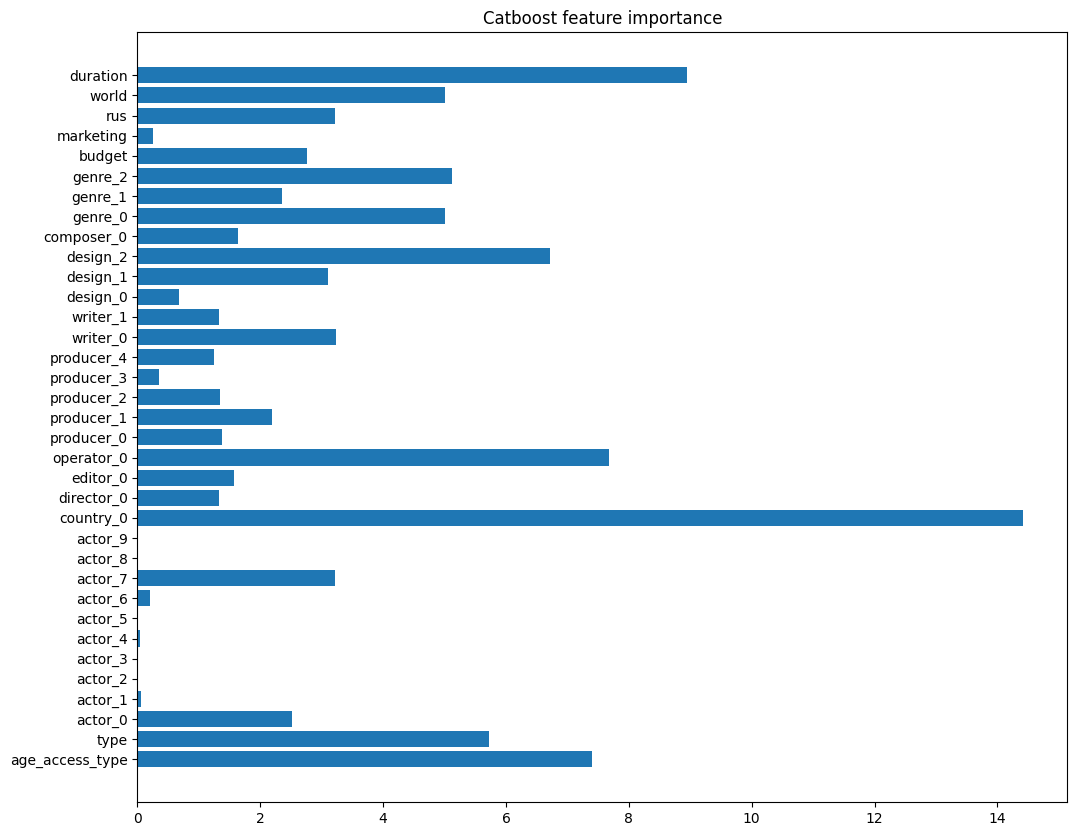

In [37]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

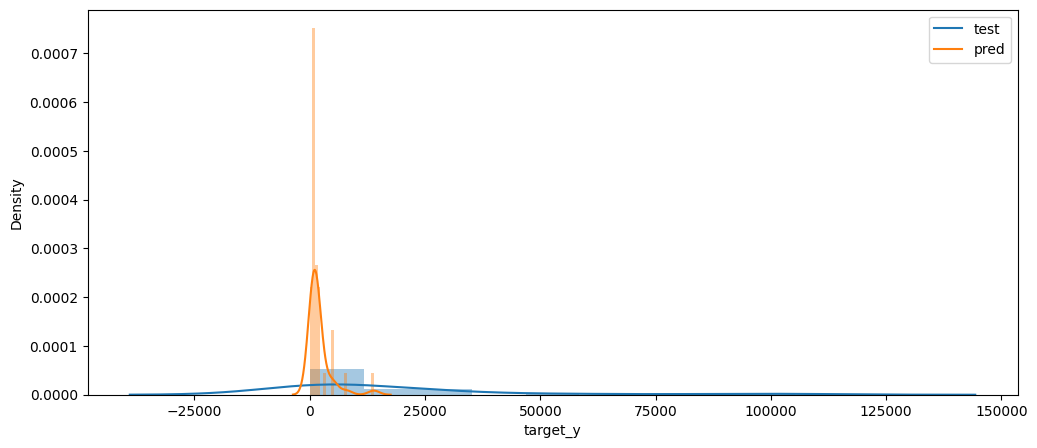

In [46]:
draw_target_distr(y_test, pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()), save_fig=False, file_name='cat_distribution')

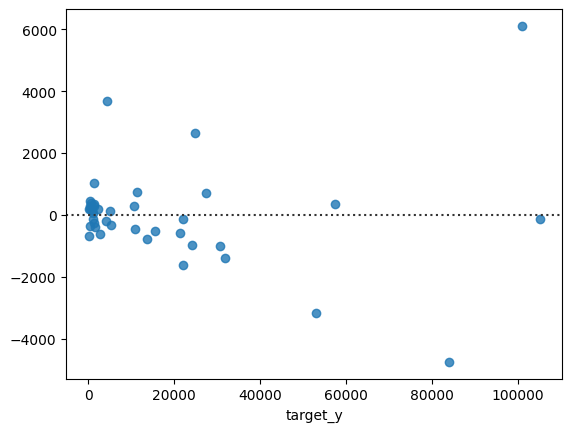

In [47]:
draw_residuals(y_test, pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()), save_fig=False)

In [48]:
len(y_pred[y_pred <= 0])

16

In [55]:
test_review = pd.concat([X_test.merge(df_pr)[['name', 'target_y']], pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()).apply(int)], axis=1)
test_review.columns = columns=['name', 'target_y', 'y_pred']

In [56]:
test_review

,name,target_y,y_pred
0,9 жизней,5159.0,689
1,День слепого Валентина,21307.0,1598
2,Предпоследняя инстанция,84084.0,1857
3,Парни под прикрытием,10952.0,978
4,Танцы на углях,1543.0,387
5,Тюрьма суперзлодеев,22111.0,611
6,Русские грузины. Фильм второй,167.0,-13
7,Кабинет Путешественника,1389.0,1806
8,Наш флаг означает Смерть,599.0,1077
9,Номинация,24847.0,5046
